In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
%matplotlib inline

In [3]:
!kaggle competitions download -c plant-seedlings-classification

100%|███████████████████████████████████████| 1.69G/1.69G [22:17<00:00, 969kB/s]
100%|██████████████████████████████████████| 1.69G/1.69G [22:17<00:00, 1.35MB/s]


In [12]:
BASE_DATA_FOLDER = "./input"
TRAIN_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

In [13]:
images_per_class = {}
for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

In [14]:
#printing number of images per class
for key, value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

Cleavers -> 287
Sugar beet -> 385
Common Chickweed -> 611
Loose Silky-bent -> 654
Scentless Mayweed -> 516
Shepherds Purse -> 231
Fat Hen -> 475
Common wheat -> 221
Black-grass -> 263
Small-flowered Cranesbill -> 496
Charlock -> 390
Maize -> 221


In [18]:
def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize = (6,6))
    
    n = 0
    
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n])
            n = n + 1
            

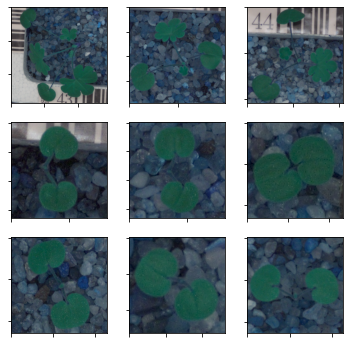

In [19]:
plot_for_class("Small-flowered Cranesbill")

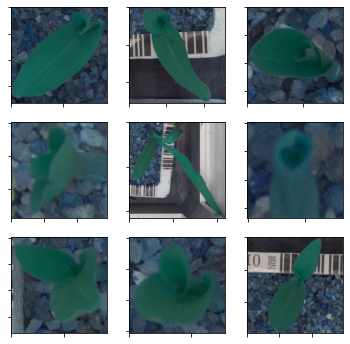

In [20]:
plot_for_class("Maize")

In [21]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

In [22]:
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output
    

In [23]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0,0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

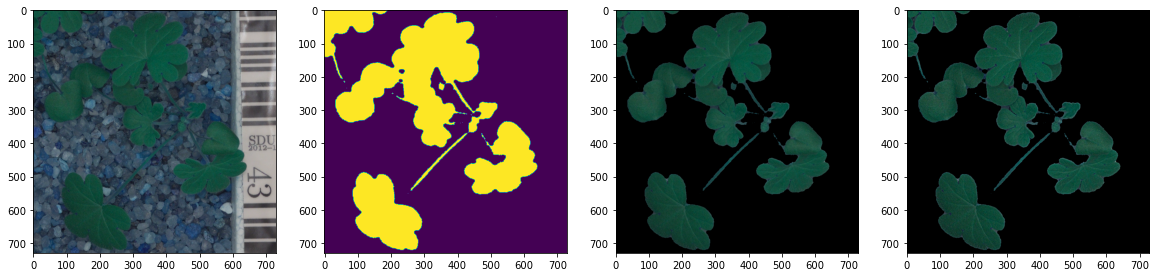

In [27]:
image = images_per_class["Small-flowered Cranesbill"][123]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize = (20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [28]:
def find_contours(mask_image):
    return cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

In [29]:
def calculate_largest_contour_area(contours):
    if(len(contours) == 0):
        return 0
    c = max(contours, key = cv2.contourArea)
    return cv2.contourArea(c)

In [31]:
def calculate_contours_area(contours, min_contour_area = 250):
    area = 0
    for c in contours:
        c_area = cv2.contourArea(c)
        if c_area >= min_contour_area:
            area = area + c_area
    return area

In [32]:
areas = []
largest_contour_areas = []
labels = []
number_of_contours = []
image_height = []
image_width = []

for class_label in images_per_class.keys():
    for image in images_per_class[class_label]:
        mask = create_mask_for_plant(image)
        contours = find_contours(mask)
        
        area = calculate_contours_area(contours)
        largest_area = calculate_largest_contour_area(contours)
        height, width, channels = image.shape
        
        image_height.append(height)
        image_width.append(width)
        areas.append(area)
        number_of_contours.append(len(contours))
        largest_contour_areas.append(largest_area)
        labels.append(class_label)


In [33]:
features_df = pd.DataFrame()
features_df["label"] = labels
features_df["area"] = areas
features_df["largest_area"] = largest_contour_areas
features_df["number_of_components"] = number_of_contours
features_df["heght"] = image_height
features_df["width"] = image_width

In [34]:
features_df.groupby("label").describe()

area                                        \
                           count           mean            std     min   
label                                                                    
Black-grass                263.0   41793.982890  159636.952451     0.0   
Charlock                   390.0   91669.094872  150626.968468  3177.5   
Cleavers                   287.0   25619.073171   24726.375631   567.5   
Common Chickweed           611.0   14935.878887   20172.494215     0.0   
Common wheat               221.0    6949.357466    8161.181143     0.0   
Fat Hen                    475.0   30623.629474   67760.225738   512.0   
Loose Silky-bent           654.0   24618.366208  132431.879535     0.0   
Maize                      221.0  115311.341629  206882.627747   851.5   
Scentless Mayweed          516.0   15517.381783   27678.754205     0.0   
Shepherds Purse            231.0   38187.586580   66440.811037   562.0   
Small-flowered Cranesbill  496.0   38126.337702   48735.741208   678.5   
Sugar beet                 385.0   79003.370130  112091.057669     0.0   

                                                                       \
                                 25%       50%         75%        max   
label                                                                   
Black-grass                 1559.750   7204.00   23556.250  2097133.5   
Charlock                   12795.125  39382.25   80786.125  1193936.5   
Cleavers                    8368.000  18717.50   34363.000   175187.0   
Common Chickweed            1917.500   5026.00   25140.000   131654.5   
Common wheat                1883.000   4044.50    8953.000    57880.0   
Fat Hen                     2804.250   6153.50   28209.000   561161.5   
Loose Silky-bent             718.500   1795.50    8252.500  1930040.5   
Maize                       3885.500  52033.00  119356.000  1435536.5   
Scentless Mayweed           1589.250   3314.25   14044.125   198328.5   
Shepherds Purse             3303.500   7435.50   45623.250   415662.5   
Small-flowered Cranesbill   7834.625  16201.50   42556.500   306815.5   
Sugar beet                 16029.000  40748.50   81174.000   815699.0   

                          largest_area                ...   heght          \
                                 count          mean  ...     75%     max   
label                                                 ...                   
Black-grass                      263.0  34209.760456  ...  906.00  2670.0   
Charlock                         390.0  83826.048718  ...  514.75  1582.0   
Cleavers                         287.0  16103.222997  ...  423.00   866.0   
Common Chickweed                 611.0  14255.498363  ...  376.50   718.0   
Common wheat                     221.0   4791.024887  ...  651.00  1432.0   
Fat Hen                          475.0  15670.149474  ...  369.00  1273.0   
Loose Silky-bent                 654.0  19345.834862  ...  534.75  3457.0   
Maize                            221.0  97378.052036  ...  706.00  1900.0   
Scentless Mayweed                516.0  14186.659884  ...  363.50  1227.0   
Shepherds Purse                  231.0  36515.952381  ...  400.00  1317.0   
Small-flowered Cranesbill        496.0  16841.354839  ...  459.25  1006.0   
Sugar beet                       385.0  58560.200000  ...  744.00  1715.0   

                           width                                         \
                           count        mean         std    min     25%   
label                                                                     
Black-grass                263.0  668.638783  520.794148   73.0  290.00   
Charlock                   390.0  431.982051  287.746036  121.0  188.00   
Cleavers                   287.0  310.292683  151.918747   66.0  171.50   
Common Chickweed           611.0  230.708674  160.842547   54.0  107.50   
Common wheat               221.0  440.171946  303.226509   51.0  136.00   
Fat Hen                    475.0  303.008421  210.947401   55.0  